In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-python

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import Sequence


In [4]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

\content\datasets\Student-engagement-dataset
C:\content\datasets\Student-engagement-dataset


In [5]:

# Paths for dataset
data_dir = '/content/datasets/Student-engagement-dataset'
output_dir = '/content/datasets'

# List of folder names in your dataset
folder_names = os.listdir(data_dir)

# Create train and validation directories if they don't exist
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split the data into training and validation sets
for folder_name in folder_names:
    folder_path = os.path.join(data_dir, folder_name)
    images = os.listdir(folder_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create subfolders in train and validation directories
    train_folder_path = os.path.join(train_dir, folder_name)
    val_folder_path = os.path.join(val_dir, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(val_folder_path, exist_ok=True)

    # Move images to corresponding subfolders
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(train_folder_path, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(val_folder_path, image))

print("Data successfully split into training and validation sets.")

# Create data generators for training and validation with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation set

# Ensure target_size is (200, 200) to match your input size
target_size = (200, 200)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,  # Adjusting to match your input size
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,  # Adjusting to match your input size
    batch_size=32,
    class_mode='categorical')

# Load the VGG16 model and modify input shape to (200, 200, 3)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Custom data generator to provide the same input to both models
class CustomDataGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        return (batch_x, batch_x), batch_y

# Wrap the original generators
custom_train_generator = CustomDataGenerator(train_generator)
custom_val_generator = CustomDataGenerator(val_generator)




# Define your custom CNN model
#input_custom_cnn = Input(shape=(200, 200, 3))
#x = tf.keras.layers.Conv2D(32, (1, 1), activation='relu')(input_custom_cnn)
#x = tf.keras.layers.MaxPooling2D((3, 3))(x)
#x = tf.keras.layers.Conv2D(64, (1, 1), activation='relu')(x)
#x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = tf.keras.layers.MaxPooling2D((3, 3))(x)
#x = tf.keras.layers.Conv2D(128, (1, 1), activation='relu')(x)
#x = tf.keras.layers.Conv2D(128, (5, 5), activation='relu')(x)
#x = tf.keras.layers.MaxPooling2D((3, 3))(x)
#x = tf.keras.layers.Conv2D(256, (1, 1), activation='relu')(x)
#x = tf.keras.layers.Conv2D(256, (5, 5), activation='relu')(x)
#custom_cnn_output = Flatten()(x)

input_custom_cnn = Input(shape=(200, 200, 3))
# First convolutional block
x = Conv2D(32, (3, 3), activation='relu')(input_custom_cnn)
x = MaxPooling2D((2, 2))(x)
# Second convolutional block
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
# Third convolutional block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
# Flatten the output
custom_cnn_output = Flatten()(x)


# Flatten the VGG16 output
vgg_output = Flatten()(vgg_model.output)

# Concatenate the outputs of the two models
combined_features = Concatenate()([custom_cnn_output, vgg_output])

# Add fully connected layers after concatenation
x = Dense(512, activation='relu')(combined_features)
output = Dense(train_generator.num_classes, activation='softmax')(x)


Data successfully split into training and validation sets.
Found 1694 images belonging to 6 classes.
Found 426 images belonging to 6 classes.


In [6]:

# Create the combined model
combined_model = Model(inputs=[input_custom_cnn, vgg_model.input], outputs=output)

# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
combined_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 198, 198,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 99, 99,    │          0 │ conv2d[0][0]    

 Total params: 58,917,254 (224.75 MB)

 Trainable params: 58,917,254 (224.75 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the combined model using the custom generators

log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

combined_model.fit(
    custom_train_generator,
    epochs=100,
    validation_data=custom_val_generator,
    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100


C:\Users\oumei_fvs20aj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 845s 16s/step - accuracy: 0.3288 - loss: 2.7532 - val_accuracy: 0.9038 - val_loss: 0.4418
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 938s 17s/step - accuracy: 0.7612 - loss: 0.5656 - val_accuracy: 0.8521 - val_loss: 0.4166
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 871s 16s/step - accuracy: 0.8167 - loss: 0.4070 - val_accuracy: 0.8075 - val_loss: 0.2776
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 862s 16s/step - accuracy: 0.8442 - loss: 0.3407 - val_accuracy: 0.8803 - val_loss: 0.2622
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 829s 15s/step - accuracy: 0.8614 - loss: 0.3458 - val_accuracy: 0.8826 - val_loss: 0.2492
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 832s 15s/step - accuracy: 0.8792 - loss: 0.2819 - val_accuracy: 0.9390 - val_loss: 0.1448
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 829s 15s/step - accuracy: 0.9180 - loss: 0.1998 - val_accuracy: 0.9484 - val_loss: 0.1215
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 929s 17s/step - accuracy: 0.8955 - loss: 0.2205 - val_accuracy: 0.8521

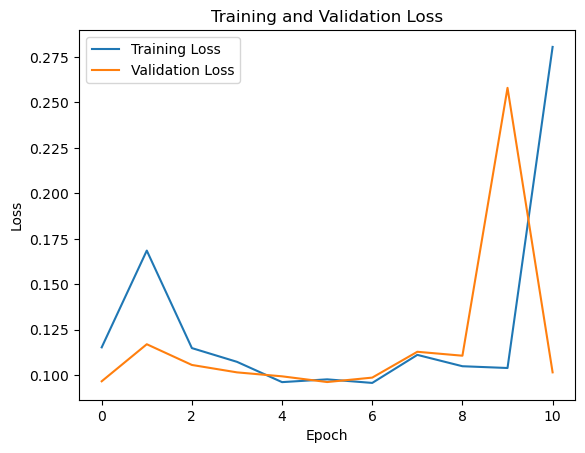

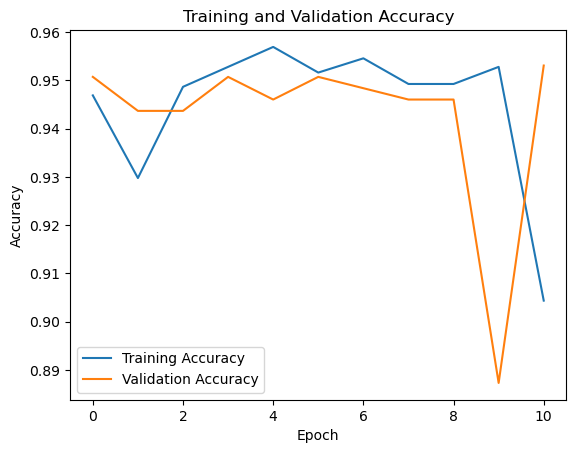

In [15]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(model):
    # Plot training loss
    plt.plot(model.history.history['loss'], label='Training Loss')
    # Check if validation loss is compiled in the model
    if 'val_loss' in model.history.history:
        plt.plot(model.history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training accuracy
    plt.plot(model.history.history['accuracy'], label='Training Accuracy')
    # Check if validation accuracy is compiled in the model
    if 'val_accuracy' in model.history.history:
        plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have already compiled and trained your model
# combined_model.compile(optimizer='adam', loss='...', metrics=['accuracy'])
# history = combined_model.fit(custom_train_generator, epochs=100, validation_data=custom_val_generator, callbacks=[tensorboard_callback, early_stopping])

# Now you can plot the loss and accuracy using the model object
plot_loss_accuracy(combined_model)


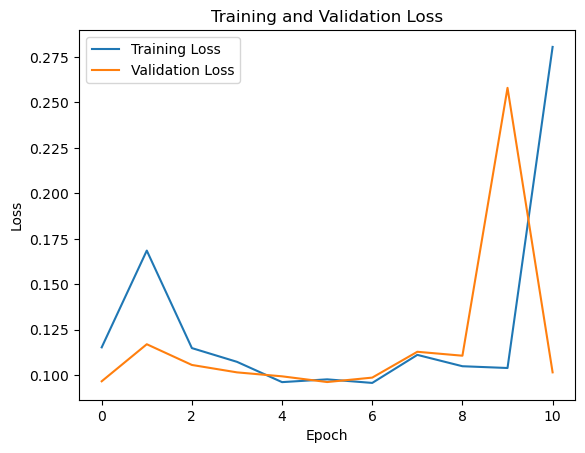

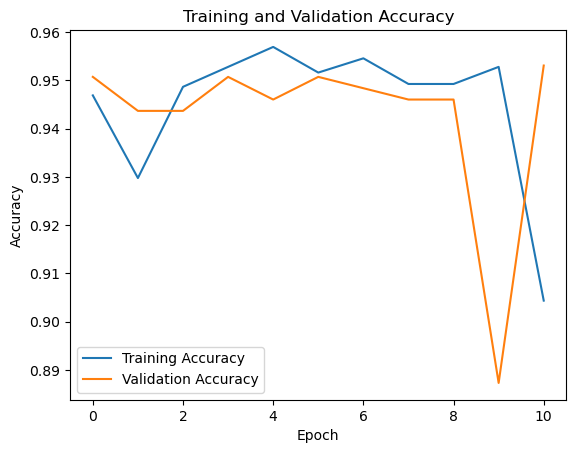

In [13]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(model):
    # Plot training loss
    plt.plot(model.history.history['loss'], label='Training Loss')
    # Check if validation loss is compiled in the model
    if 'val_loss' in model.history.history:
        plt.plot(model.history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training accuracy
    plt.plot(model.history.history['accuracy'], label='Training Accuracy')
    # Check if validation accuracy is compiled in the model
    if 'val_accuracy' in model.history.history:
        plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have already compiled and trained your model
# combined_model.compile(optimizer='adam', loss='...', metrics=['accuracy'])
# history = combined_model.fit(custom_train_generator, epochs=100, validation_data=custom_val_generator, callbacks=[tensorboard_callback, early_stopping])

# Now you can plot the loss and accuracy using the model object
plot_loss_accuracy(combined_model)


In [11]:

history = combined_model.fit(
    custom_train_generator,
    epochs=100,
    validation_data=custom_val_generator,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 806s 15s/step - accuracy: 0.9583 - loss: 0.1022 - val_accuracy: 0.9507 - val_loss: 0.0967
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 793s 15s/step - accuracy: 0.9228 - loss: 0.1683 - val_accuracy: 0.9437 - val_loss: 0.1170
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 811s 15s/step - accuracy: 0.9397 - loss: 0.1292 - val_accuracy: 0.9437 - val_loss: 0.1056
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 801s 15s/step - accuracy: 0.9491 - loss: 0.1142 - val_accuracy: 0.9507 - val_loss: 0.1016
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 803s 15s/step - accuracy: 0.9537 - loss: 0.1020 - val_accuracy: 0.9460 - val_loss: 0.0994
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 796s 15s/step - accuracy: 0.9652 - loss: 0.0815 - val_accuracy: 0.9507 - val_loss: 0.0963
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 805s 15s/step - accuracy: 0.9579 - loss: 0.0941 - val_accuracy: 0.9484 - val_loss: 0.0987
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 781s 15s/step - accuracy: 0.9491 - loss: 0.1072 - val_accu

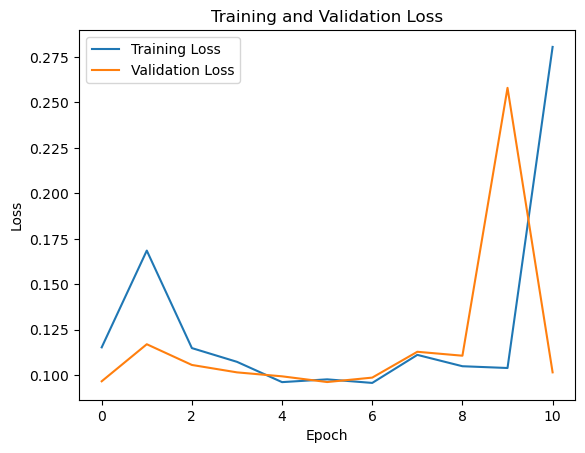

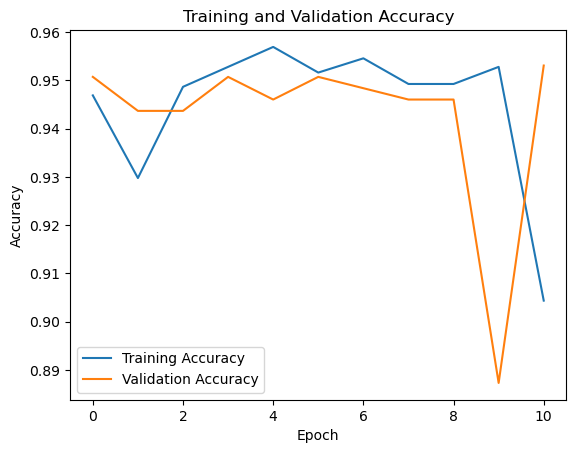

In [12]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# Check if validation loss is recorded in the history
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# Check if validation accuracy is recorded in the history
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
# Evaluate the model on the validation data
evaluation = combined_model.evaluate(custom_val_generator)

# Print the evaluation results
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])


14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9404 - loss: 0.1039
Validation Loss: 0.09625222533941269
Validation Accuracy: 0.9507042169570923
